# 迷你项目：时间差分方法

在此 notebook 中，你将自己编写很多时间差分 (TD) 方法的实现。

虽然我们提供了一些起始代码，但是你可以删掉这些提示并从头编写代码。

### 第 0 部分：探索 CliffWalkingEnv

请使用以下代码单元格创建 [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) 环境的实例。

In [2]:
import gym
env = gym.make('CliffWalking-v0')

智能体会在 $4\times 12$ 网格世界中移动，状态编号如下所示：

In [4]:
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]

在任何阶段开始时，初始状态都是状态 `36`。状态 `47`是唯一的终止状态，悬崖对应的是状态 `37` 到 `46`。

智能体可以执行 4 个潜在动作：

In [5]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

因此，$\mathcal{S}^+=\{0, 1, \ldots, 47\}$ 以及 $\mathcal{A} =\{0, 1, 2, 3\}$。请通过运行以下代码单元格验证这一点。

In [6]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


在此迷你项目中，我们将逐步发现 CliffWalking 环境的最优策略。最优状态值函数可视化结果如下。请立即花时间确保理解_为何_ 这是最优状态值函数。

In [3]:
import numpy as np
from plot_utils import plot_values

# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

# plot_values(V_opt)
print(V_opt)

[[-14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.]
 [-13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.]
 [-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.]
 [-13.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]


### 第 1 部分：TD 预测 - 状态值

在此部分，你将自己编写 TD 预测的实现（用于估算状态值函数）。

我们首先将研究智能体按以下方式移动的策略：
- 在状态 `0` 到 `10`（含）时向 `RIGHT` 移动， 
- 在状态 `11`、`23` 和 `35` 时向 `DOWN` 移动，
- 在状态 `12` 到 `22`（含）、状态 `24` 到 `34`（含）和状态 `36` 时向 `UP`移动。

下面指定并输出了该策略。注意，智能体没有选择动作的状态被标记为 `-1`。

In [9]:
policy = np.hstack([1*np.ones(11), 2, 0, np.zeros(10), 2, 0, np.zeros(10), 2, 0, -1*np.ones(11)])
print("\nPolicy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy.reshape(4,12))


Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]


请运行下个单元格，可视化与此策略相对应的状态值函数。你需要确保花时间来理解为何这是对应的值函数！

/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one

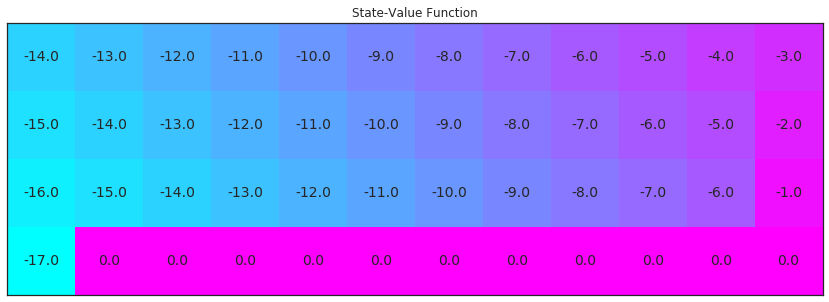

In [10]:
V_true = np.zeros((4,12))
for i in range(3):
    V_true[0:12][i] = -np.arange(3, 15)[::-1] - i
V_true[1][11] = -2
V_true[2][11] = -1
V_true[3][0] = -17

plot_values(V_true)

你将通过 TD 预测算法尝试逼近上图的结果。

你的 TD 预测算法将包括 5 个参数：
- `env`：这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `policy`：这是一个一维 numpy 数组，其中 `policy.shape` 等于状态数量 (`env.nS`)。`policy[s]` 返回智能体在状态 `s` 时选择的动作。
- `alpha`：这是更新步骤的步长参数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：
- `V`：这是一个字典，其中 `V[s]` 是状态 `s` 的估算值。 

请完成以下代码单元格中的函数。

In [6]:
from collections import defaultdict, deque
import sys

def td_prediction(env, num_episodes, policy, alpha, gamma=1.0):
    # initialize empty dictionaries of floats
    V = defaultdict(float)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        state = env.reset()
        while True:
            # choose action follow given policy
            action = policy[state]
            # get next_state and reward
            next_state, reward, done, _ = env.step(action)
            # Use new state to update old state-value function
            V[state] += alpha * (reward + gamma * V[next_state] - V[state])
            state = next_state
            if done:
                break
        
    return V 

请运行以下代码单元格，以测试你的实现并可视化估算的状态值函数。如果代码单元格返回 **PASSED**，则表明你正确地实现了该函数！你可以随意更改提供给该函数的 `num_episodes` 和 `alpha` 参数。但是，如果你要确保单元测试的准确性，请勿更改 `gamma` 的默认值。

Episode 5000/5000

**<span style="color: green;">PASSED</span>**

/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one

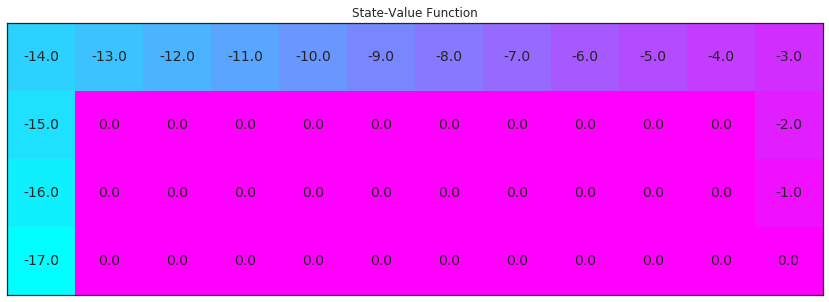

In [12]:
import check_test

# evaluate the policy and reshape the state-value function
V_pred = td_prediction(env, 5000, policy, .01)

# please do not change the code below this line
V_pred_plot = np.reshape([V_pred[key] if key in V_pred else 0 for key in np.arange(48)], (4,12)) 
check_test.run_check('td_prediction_check', V_pred_plot)
plot_values(V_pred_plot)

你的估算状态值函数与该策略对应的真状态值函数有多接近？ 

你可能注意到了，有些状态值不是智能体估算的。因为根据该策略，智能体不会经历所有状态。在 TD 预测算法中，智能体只能估算所经历的状态对应的值。

### 第 2 部分：TD 控制 - Sarsa

在此部分，你将自己编写 Sarsa 控制算法的实现。

你的算法将有四个参数：
- `env`：这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `alpha`：这是更新步骤的步长参数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：

- `Q`：这是一个字典（一维数组），其中 `Q[s][a]` 是状态 `s` 和动作 `a` 对应的估算动作值。

请完成以下代码单元格中的函数。

（_你可以随意定义其他函数，以帮助你整理代码。_）

In [1]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        state = env.reset()
        policy_prob = epsilon_greedy_prob(env, Q[state], i_episode)
        
        # Pick an action
        action = np.random.choice(np.arange(env.nA), p=policy_prob)
        
        for t in np.arange(300):
            next_state, reward, done, _ = env.step(action)
    
            if done:
                
                # next step is 0
                Q[state][action] = update_Q(Q[state][action], 0, reward, alpha, gamma)
                
                break
            
            else:
                
                # Make an epsilon selection based on the current Q
                policy_prob = epsilon_greedy_prob(env, Q[next_state], i_episode)
                next_action = np.random.choice(np.arange(env.nA), p=policy_prob)
                
                # Update Q after selecting the action
                Q[state][action] = update_Q(Q[state][action], Q[next_state][next_action],
                                           reward, alpha, gamma)
                
                state = next_state
                action = next_action
        
    return Q


def epsilon_greedy_prob(env, q, i_episode, eps=None):
    """
    Given all the action values of a state, generate the probability of
    selecting these actions based on the epsilon greedy strategy
    """
    epsilon = 1.0 / i_episode
    if eps is not None:
        epsilon = eps

    policy_p = np.ones(env.nA) * epsilon / env.nA
    # Change the probability of greedy action separately
    policy_p[np.argmax(q)] = 1 - epsilon + (epsilon / env.nA)
    return policy_p


def update_Q(Qsa, Qsa_next, reward, alpha, gamma):
    return Qsa + (alpha * (reward + (gamma * Qsa_next) - Qsa))

请使用下个代码单元格可视化**_估算的_**最优策略和相应的状态值函数。  

如果代码单元格返回 **PASSED**，则表明你正确地实现了该函数！你可以随意更改提供给该函数的 `num_episodes` 和 `alpha` 参数。但是，如果你要确保单元测试的准确性，请勿更改 `gamma` 的默认值。

Episode 5000/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  1  0  3  0  0  1  1  0  2  2]
 [ 0  1  1  1  1  1  1  3  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one

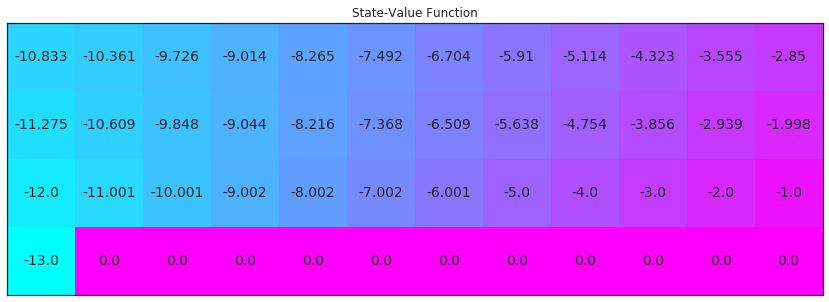

In [14]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### 第 3 部分：TD 控制 - Q 学习

在此部分，你将自己编写 Q 学习控制算法的实现。

你的算法将有四个参数：

- `env`：这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `alpha`：这是更新步骤的步长参数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：

- `Q`：这是一个字典（一维数组），其中 `Q[s][a]` 是状态 `s` 和动作 `a` 对应的估算动作值。

请完成以下代码单元格中的函数。

（_你可以随意定义其他函数，以帮助你整理代码。_）

In [4]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        state = env.reset()

        for i in range(500):
            policy_prob = epsilon_greedy_prob(env, Q[state], i_episode)
            action = np.random.choice(np.arange(env.nA))

            next_state, reward, done, _ = env.step(action)
            Q[state][action] = update_Q(Q[state][action], np.max(Q[next_state]), reward, alpha, gamma)
            
            state = next_state
            
            if done:
                break

    return Q

请使用下个代码单元格可视化**_估算的_**最优策略和相应的状态值函数。  

如果代码单元格返回 **PASSED**，则表明你正确地实现了该函数！你可以随意更改提供给该函数的 `num_episodes` 和 `alpha` 参数。但是，如果你要确保单元测试的准确性，请勿更改 `gamma` 的默认值。

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/lazycat/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one

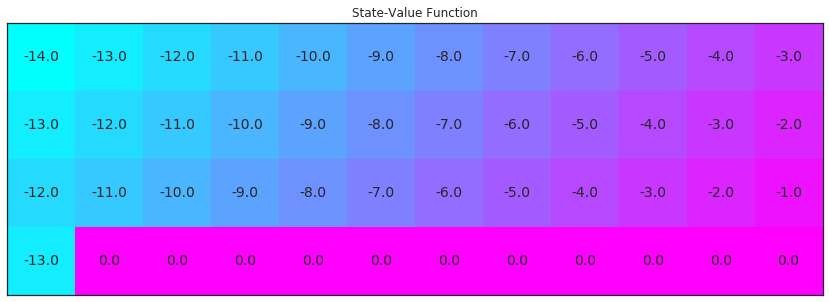

In [9]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)
import check_test
# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### 第 4 部分：TD 控制 - 预期 Sarsa

在此部分，你将自己编写预期 Sarsa 控制算法的实现。

你的算法将有四个参数：

- `env`：这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `alpha`：这是更新步骤的步长参数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：

- `Q`：这是一个字典（一维数组），其中 `Q[s][a]` 是状态 `s` 和动作 `a` 对应的估算动作值。

请完成以下代码单元格中的函数。

（_你可以随意定义其他函数，以帮助你整理代码。_）

In [ ]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        state = env.reset()
        policy_prob = epsilon_greedy_prob(env, Q[state], i_episode, 0.005)
        
        while True:
            action = np.random.choice(np.arange(env.nA), p=policy_prob)
            
            next_state, reward, done, _ = env.step(action)
            
            policy_prob = epsilon_greedy_prob(env, Q[next_state], i_episode, 0.005)
            
            Q[state][action] = update_Q(Q[state][action], np.dot(Q[next_state], policy_prob), reward, alpha, gamma)
            
        
    return Q

请使用下个代码单元格可视化**_估算的_**最优策略和相应的状态值函数。  

如果代码单元格返回 **PASSED**，则表明你正确地实现了该函数！你可以随意更改提供给该函数的 `num_episodes` 和 `alpha` 参数。但是，如果你要确保单元测试的准确性，请勿更改 `gamma` 的默认值。

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])